
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 確率的勾配降下法

:ラベル: `sec_sgd`

前の章では、トレーニング手順で確率的勾配降下法を使用し続けましたが、なぜそれが機能するのかについては説明していませんでした。これをわかりやすくするために、 :numref: `sec_gd`で勾配降下法の基本原理を説明しました。このセクションでは、*確率的勾配降下法*についてさらに詳しく説明します。


In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l


## 確率的勾配更新

深層学習では、目的関数は通常、トレーニング データセット内の各サンプルの損失関数の平均です。 $n$ の例のトレーニング データセットが与えられた場合、$f_i(\mathbf{x})$ がインデックス $i$ のトレーニング例に関する損失関数であると仮定します。$\mathbf{x}$ はパラメーターです。ベクター。次に、目的関数に到達します

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

 $\mathbf{x}$ における目的関数の勾配は次のように計算されます。

 $$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

勾配降下法が使用される場合、各独立変数反復の計算コストは​​ $\mathcal{O}(n)$ となり、$n$ に応じて線形に増加します。したがって、トレーニング データセットが大きくなると、反復ごとの勾配降下のコストが高くなります。

確率的勾配降下法 (SGD) により、反復ごとの計算コストが削減されます。確率的勾配降下法の各反復で、データ例のインデックス $i\in{1,\ldots, n}$ をランダムにサンプリングし、更新する勾配 $\nabla f_i(\mathbf{x})$ を計算します。 $\mathbf{x}$:

 $$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

ここで、$\eta$ は学習率です。各反復の計算コストが、勾配降下法の $\mathcal{O}(n)$ から定数 $\mathcal{O}(1)$ まで低下することがわかります。さらに、確率的勾配 $\nabla f_i(\mathbf{x})$ は完全な勾配 $\nabla f(\mathbf{x})$ の不偏推定値であることを強調したいと思います。

 $$\mathbb{E} *i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum* {i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f (\mathbf{x}).$$

これは、平均して、確率的勾配が勾配の適切な推定値であることを意味します。

ここで、平均 0、分散 1 のランダム ノイズを勾配に追加して確率的勾配降下法をシミュレートすることにより、それを勾配降下法と比較します。


In [2]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

In [3]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: 0.014749, x2: 0.009829


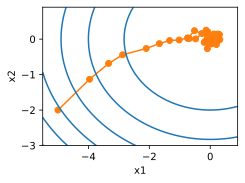

In [4]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))


ご覧のとおり、確率的勾配降下法の変数の軌跡は、 :numref: `sec_gd`の勾配降下法で観察したものよりもはるかにノイズが多くなります。これは、勾配の確率的な性質によるものです。つまり、最小値付近に到達した場合でも、$\eta \nabla f_i(\mathbf{x})$ を介して瞬間的な勾配によって注入される不確実性の影響を受け続けます。 50 のステップを経ても、品質はまだそれほど良くありません。さらに悪いことに、手順を追加しても改善されません (これを確認するために、より多くの手順を試してみることをお勧めします)。これにより、学習率 $\eta$ を変更するという唯一の選択肢が残されます。ただし、これを小さすぎると、最初は意味のある進歩が得られません。一方、選択しすぎると、上で見たように、適切な解決策は得られません。これらの矛盾する目標を解決する唯一の方法は、最適化の進行に応じて学習率を*動的に*下げることです。

これは、学習率関数`lr` `sgd`ステップ関数に追加する理由でもあります。上記の例では、関連する`lr`関数を定数に設定しているため、学習率スケジューリングの機能はすべて休止状態になります。

## 動的学習率

$\eta$ を時間依存学習率 $\eta(t)$ に置き換えると、最適化アルゴリズムの収束制御がさらに複雑になります。特に、$\eta$ がどれくらいの速度で減衰するかを把握する必要があります。速すぎる場合は、最適化が途中で停止されます。減らすのが遅すぎると、最適化に時間がかかりすぎます。以下は、時間の経過とともに $\eta$ を調整する際に使用されるいくつかの基本的な戦略です (より高度な戦略については後で説明します)。

 $$ \begin{aligned} \eta(t) &amp; = \eta_i \text{ if } t_i \leq t \leq t_{i+1} &amp;&amp; \text{区分定数} \ \eta(t) &amp; = \eta_0 \cdot e^{-\lambda t} &amp;&amp; \text{指数関数的減衰} \ \eta(t) &amp; = \eta_0 \cdot (\beta t + 1)^{-\alpha} &amp;&amp; \text{多項式減衰} \終了{整列} $$

最初の*区分一定*シナリオでは、たとえば最適化の進行が停滞するたびに学習率を下げます。これは、ディープ ネットワークをトレーニングするための一般的な戦略です。あるいは、*指数関数的な減衰*によって、より積極的に減少させることもできます。残念ながら、これによりアルゴリズムが収束する前に途中で停止してしまうことがよくあります。一般的な選択は、$\alpha = 0.5$ の*多項式減衰*です。凸最適化の場合、このレートが適切に動作することを示す証拠が多数あります。

実際に指数関数的減衰がどのように見えるかを見てみましょう。


epoch 1000, x1: -0.878960, x2: -0.023958


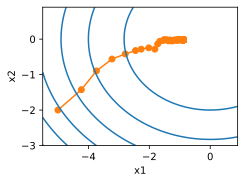

In [5]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))


予想通り、パラメータの分散は大幅に減少しました。ただし、これには最適解 $\mathbf{x} = (0, 0)$ に収束できないという代償が伴います。 1,000 回の反復ステップを経ても、最適解にはまだ程遠いです。実際、アルゴリズムはまったく収束しません。一方、学習率がステップ数の逆平方根に応じて減衰する多項式減衰を使用すると、わずか 50 ステップで収束が向上します。


epoch 50, x1: -0.060831, x2: 0.028779


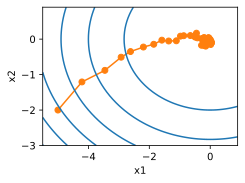

In [6]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))


学習率を設定する方法には、さらに多くの選択肢があります。たとえば、小さなレートから始めて、その後急速に増加させ、その後、よりゆっくりではありますが、再び減少させることができます。学習率を小さくしたり大きくしたりすることもできます。このようなスケジュールには多種多様なものが存在する。ここでは、包括的な理論分析が可能な学習率スケジュール、つまり凸型設定での学習率に焦点を当てましょう。一般に非線形非凸問題の場合、非線形非凸問題を最小化するのは NP が難しいため、意味のある収束保証を得るのは非常に困難です。調査については、たとえば Tibshirani 2015 の優れた[講義ノート](https://www.stat.cmu.edu/%7Eryantibs/convexopt-F15/lectures/26-nonconvex.pdf)を参照してください。

## 凸型対物レンズの収束解析

凸目的関数の確率的勾配降下の次の収束解析はオプションであり、主に問題についてのより多くの直観を伝えるために役立ちます。最も単純な証明の 1 つに限定します :cite: `Nesterov.Vial.2000` 。たとえば、目的関数が特に適切に動作する場合には、非常に高度な証明技術が存在します。

目的関数 $f(\boldsymbol{\xi}, \mathbf{x})$ がすべての $\boldsymbol{\xi}$ に対して $\mathbf{x}$ に凸であるとします。より具体的には、確率的勾配降下法更新を検討します。

 $$\mathbf{x} *{t+1} = \mathbf{x}* {t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}),$$

ここで、$f(\boldsymbol{\xi}_t, \mathbf{x})$ は、ステップ $t$ および $\ で何らかの分布から抽出されたトレーニング例 $\boldsymbol{\xi}_t$ に関する目的関数です。 mathbf{x}$ はモデルパラメータです。で示す

$$R(\mathbf{x}) = E_{\boldsymbol{\xi}}[f(\boldsymbol{\xi}, \mathbf{x})]$$

予想されるリスクと $R^ *$ による $\mathbf{x}$ に関する最小値。最後に $\mathbf{x}^* $ をミニマイザーとします ($\mathbf{x}$ が定義されているドメイン内にミニマイザーが存在すると仮定します)。この場合、$t$ 時点での現在のパラメーター $\mathbf{x}_t$ とリスク最小化パラメーター $\mathbf{x}^*$ の間の距離を追跡し、それが時間の経過とともに改善されるかどうかを確認できます。

 $$\begin{aligned} &amp;|\mathbf{x} *{t+1} - \mathbf{x}^*|^2 \ =&amp; |\mathbf{x} {* t} - \eta_t \partial_\mathbf{ x} f(\boldsymbol{\xi} *t, \mathbf{x}) - \mathbf{x}^*|^2 \ =&amp; |\mathbf{x} {* t} - \mathbf{x}^ *|^ 2 + \eta_t^2 |\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})|^2 - 2 \eta_t \left\langle \mathbf{x}_t - \mathbf {x}^* , \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\right\rangle. \end{整列}$$ :eqlabel: `eq_sgd-xt+1-xstar`

確率的勾配 $\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})$ の $\ell_2$ ノルムは、ある定数 $L$ によって制限されると仮定します。

 $$\eta_t^2 |\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})|^2 \leq \eta_t^2 L^2.$$ :eqlabel: `eq_sgd-L`

私たちの主な関心は、 $\mathbf{x}_t$ と $\mathbf{x}^ *$ の間の距離が *期待値 でどのように変化するかです*。実際、特定の一連のステップでは、遭遇する $\boldsymbol{\xi}_t$ に応じて、距離が増加する可能性があります。したがって、内積を制限する必要があります。任意の凸関数 $f$ に対して、 $f(\mathbf{y}) \geq f(\mathbf{x}) + \langle f&#39;(\mathbf{x}), \mathbf{y} - \ が成り立つため、すべての $\mathbf{x}$ と $\mathbf{y}$ に対する mathbf{x} \rangle$ は、凸性によって次のようになります。

 *$$f(\boldsymbol{\xi} t, \mathbf{x}^*) \geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^ * - \mathbf{x}_t, \partial* {\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle.$$ :eqlabel: `eq_sgd-f-xi-xstar`

両方の不等式 :eqref: `eq_sgd-L`と :eqref: `eq_sgd-f-xi-xstar`を :eqref: `eq_sgd-xt+1-xstar`に代入すると、次のように時間 $t+1$ におけるパラメーター間の距離の限界が得られます。

 $$|\mathbf{x} *{t} - \mathbf{x}^*|^2 - |\mathbf{x}* {t+1} - \mathbf{x}^ *|^2 \geq 2 \eta_t ( f(\boldsymbol{\xi}_t, \mathbf{x}_t) - f(\boldsymbol{\xi}_t, \mathbf{x}^ )) - \eta_t^2 L^2.$$ :eqlabel:* `eqref_sgd-xt-diff`

これは、現在の損失と最適な損失の差が $\eta_t L^2/2$ を上回る限り、進歩することを意味します。この差は必ずゼロに収束するので、学習率 $\eta_t$ も*消滅する*必要があるということになります。

次に、 :eqref: `eqref_sgd-xt-diff`に対する期待を取り上げます。これにより、

 $$E\left[|\mathbf{x *} {t} - \mathbf{x}^*|^2\right] - E\left[|\mathbf{x} {* t+1} - \mathbf{x } *^ |^2\right] \geq 2 \eta_t [E[R(\mathbf{x}_t)] - R^ ]* - \eta_t^2 L^2.$$

最後のステップでは、$t \in {1, \ldots, T}$ の不等式を合計します。和が望遠鏡になるので、下位項をドロップすることにより、次の結果が得られます。

 $$|\mathbf{x} *1 - \mathbf{x}^*|^2 \geq 2 \left (\sum* {t=1}^T \eta_t \right) [E[R(\mathbf{x} *t)] - R^*] - L^2 \sum* {t=1}^T \eta_t^2.$$ :eqlabel: `eq_sgd-x1-xstar`

 $\mathbf{x}_1$ が与えられることを利用して、期待値を落とすことができることに注意してください。最後の定義

$$\bar{\mathbf{x}} \stackrel{\mathrm{def}}{=} \frac{\sum_{t=1}^T \eta_t \mathbf{x} *t}{\sum* {t= 1}^T \eta_t}.$$

以来

$$E\left(\frac{\sum_{t=1}^T \eta_t R(\mathbf{x} *t)}{\sum* {t=1}^T \eta_t}\right) = \frac{ \sum_{t=1}^T \eta_t E[R(\mathbf{x} *t)]}{\sum* {t=1}^T \eta_t} = E[R(\mathbf{x}_t)] 、$$

 Jensen の不等式 ( :eqref: `eq_jensens-inequality` inequality で $i=t$, $\alpha_i = \eta_t/\sum_{t=1}^T \eta_t$ を設定) と $R$ の凸性により、 $E[ R(\mathbf{x}_t)] \geq E[R(\bar{\mathbf{x}})]$、つまり

$$\sum_{t=1}^T \eta_t E[R(\mathbf{x} *t)] \geq \sum* {t=1}^T \eta_t E\left[R(\bar{\mathbf{ x}})\right].$$

これを不等式 :eqref: `eq_sgd-x1-xstar`に代入すると、境界が得られます。

 $$ \left[E[\bar{\mathbf{x}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2} {2 \sum_{t=1}^T \eta_t}, $$

ここで、 $r^2 \stackrel{\mathrm{def}}{=} |\mathbf{x}_1 - \mathbf{x}^*|^2$ は、最初に選択したパラメーターと、最終的な結果。つまり、収束の速度は、確率的勾配のノルムがどのように制限されるか ($L$)、および初期パラメーター値が最適性からどれだけ離れているか ($r$) に依存します。境界は $\mathbf{x}_T$ ではなく $\bar{\mathbf{x}}$ に関するものであることに注意してください。 $\bar{\mathbf{x}}$ は最適化パスの平滑化バージョンであるため、これが当てはまります。 $r、L$、$T$ が既知であれば、学習率 $\eta = r/(L \sqrt{T})$ を選択できます。これにより、上限 $rL/\sqrt{T}$ が得られます。つまり、rate $\mathcal{O}(1/\sqrt{T})$ で最適解に収束します。

## 確率的勾配と有限サンプル

ここまでは、確率的勾配降下法について話す際に、少し急ぎ足でゆるく説明してきました。通常、ある分布 $p(x, y)$ からラベル $y_i$ を持つインスタンス $x_i$ を描画し、これを使用して何らかの方法でモデル パラメーターを更新すると仮定しました。特に、サンプルサイズが有限の場合、離散分布 $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_ であると単純に主張しました。一部の関数 $\delta_{x_i}$ および $\delta_{y_i}$ の {y_i}(y)$ を使用すると、確率的勾配降下法を実行できます。

しかし、これは私たちが実際に行ったことではありません。現在のセクションのおもちゃの例では、非確率的勾配に単純にノイズを追加しました。つまり、$(x_i, y_i)$ のペアがあるふりをしました。これはここで正当化されることがわかります (詳細については演習を参照してください)。さらに問題なのは、これまでのすべての議論で、私たちが明らかにこれを行っていなかったことです。代わりに、すべてのインスタンスを*1 回だけ*繰り返しました。これがなぜ好ましいのかを確認するには、逆のこと、つまり、 *replace を使用して*離散分布から $n$ 観測値をサンプリングしていることを考えてみましょう。要素 $i$ がランダムに選択される確率は $1/n$ です。したがって、*少なくとも*一度は選択することは、

 $$P(\mathrm{選択~} i) = 1 - P(\mathrm{省略~} i) = 1 - (1-1/n)^n \約 1-e^{-1} \約 0.63 .$$

同様の推論により、あるサンプル (つまりトレーニング サンプル) を*1 回だけ*選択する確率は次の式で与えられることがわかります。

 $${n \選択 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \ left(1-\frac{1}{n}\right)^{n} \およそ e^{-1} \およそ 0.37.$$

置換を伴うサンプリングは*、置換を行わない*サンプリングと比較して分散が増加し、データ効率が低下します。したがって、実際には後者を実行します (これが本書全体のデフォルトの選択です)。最後に、トレーニング データセットを通過する繰り返しパスは、*異なる*ランダムな順序でデータセットを通過することに注意してください。

## まとめ
- 凸型問題の場合、学習率の幅広い選択に対して確率的勾配降下法が最適解に収束することを証明できます。
- 深層学習の場合、これは通常当てはまりません。ただし、凸問題の分析は、最適化へのアプローチ方法、つまり、学習率を急速ではないにしても段階的に低下させる方法についての有益な洞察を与えてくれます。
- 学習率が小さすぎるか大きすぎる場合、問題が発生します。実際には、適切な学習率は複数の実験を経て初めて見つかることがよくあります。
- トレーニング データセット内の例が増えると、勾配降下法の各反復の計算コストが高くなるため、このような場合には確率的勾配降下法が推奨されます。
- 確率的勾配降下法の最適性保証は、チェックが必要な極小値の数が指数関数的になる可能性があるため、非凸の場合には一般に利用できません。

## 演習
1. 確率的勾配降下法のさまざまな学習率スケジュールとさまざまな反復数を試してください。特に、最適解 $(0, 0)$ からの距離を反復回数の関数としてプロットします。
1. 関数 $f(x_1, x_2) = x_1^2 + 2 x_2^2$ の場合、勾配に通常のノイズを追加することは、損失関数 $f(\mathbf{x}, \mathbf{w}) を最小化することと同等であることを証明します。 = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$ ここで、$\mathbf{x}$ は正規分布から抽出されます。
1.  ${(x_1, y_1), \ldots, (x_n, y_n)}$ から置換を使用してサンプリングした場合と、置換を使用せずにサンプリングした場合の確率的勾配降下の収束を比較します。
1. ある勾配 (またはそれに関連する座標) が他のすべての勾配よりも一貫して大きい場合、確率的勾配降下法ソルバーをどのように変更しますか?
1.  $f(x) = x^2 (1 + \sin x)$ と仮定します。 $f$ には極小値がいくつありますか? $f$ を最小化するためにすべての極小値を評価する必要があるように $f$ を変更できますか?



[ディスカッション](https://discuss.d2l.ai/t/497)
